# ADS 509 Assignment 5.1: Topic Modeling

This notebook holds Assignment 5.1 for Module 5 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In this assignment you will work with a categorical corpus that accompanies `nltk`. You will build the three types of topic models described in Chapter 8 of _Blueprints for Text Analytics using Python_: NMF, LSA, and LDA. You will compare these models to the true categories. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [1]:
# These libraries may be useful to you

from nltk.corpus import brown

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import pyLDAvis
import pyLDAvis.sklearn
import pyLDAvis.gensim_models

import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

from spacy.lang.en.stop_words import STOP_WORDS as stopwords

from collections import Counter, defaultdict

#nlp = spacy.load('en_core_web_sm')
nlp = spacy.load('en_core_web_sm')

/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/lib/python3.8/site-packages/h5py/__init__.py:46: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  from ._conv import register_converters as _register_converters


In [2]:
# add any additional libaries you need here
from nltk.corpus import stopwords
from itertools import chain
import nltk
import re
import matplotlib.pyplot as plt
from nltk.probability import FreqDist
nltk.download('stopwords')
nltk.download('punkt')
stop_words = stopwords.words("english")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/datascience/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/datascience/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
# This function comes from the BTAP repo.

def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

## Getting to Know the Brown Corpus

Let's spend a bit of time getting to know what's in the Brown corpus, our NLTK example of an "overlapping" corpus.

In [4]:
# categories of articles in Brown corpus
for category in brown.categories() :
    print(f"For {category} we have {len(brown.fileids(categories=category))} articles.")

For adventure we have 29 articles.
For belles_lettres we have 75 articles.
For editorial we have 27 articles.
For fiction we have 29 articles.
For government we have 30 articles.
For hobbies we have 36 articles.
For humor we have 9 articles.
For learned we have 80 articles.
For lore we have 48 articles.
For mystery we have 24 articles.
For news we have 44 articles.
For religion we have 17 articles.
For reviews we have 17 articles.
For romance we have 29 articles.
For science_fiction we have 6 articles.


Let's create a dataframe of the articles in of hobbies, editorial, government, news, and romance.

In [5]:
categories = ['editorial','government','news','romance','hobbies'] 

category_list = []
file_ids = []
texts = []

for category in categories : 
    for file_id in brown.fileids(categories=category) :
        
        # build some lists for a dataframe
        category_list.append(category)
        file_ids.append(file_id)
        
        text = brown.words(fileids=file_id)
        texts.append(" ".join(text))

        
        
df = pd.DataFrame()
df['category'] = category_list
df['id'] = file_ids
df['text'] = texts 

df.shape

(166, 3)

In [6]:
# Let's add some helpful columns on the df
df['char_len'] = df['text'].apply(len)
df['word_len'] = df['text'].apply(lambda x: len(x.split()))


<AxesSubplot:xlabel='category'>

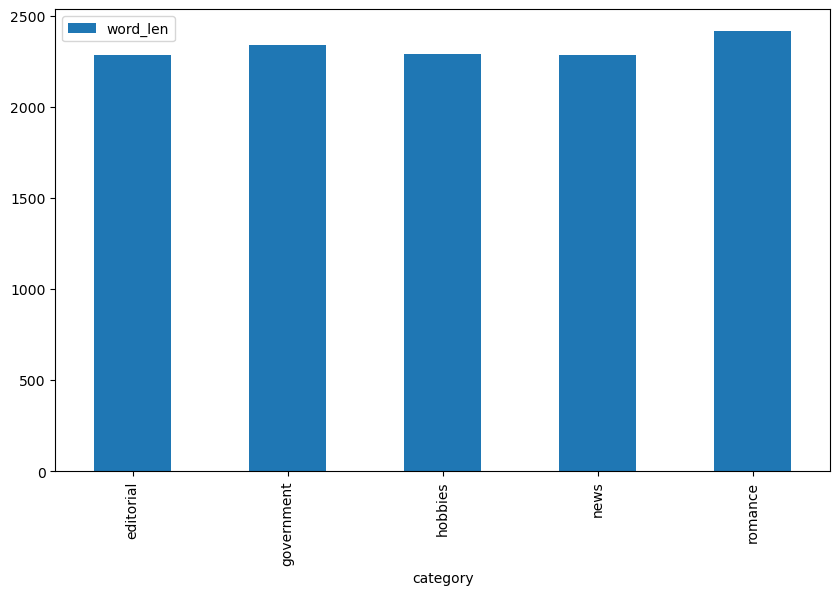

In [7]:
%matplotlib inline
df.groupby('category').agg({'word_len': 'mean'}).plot.bar(figsize=(10,6))

Now do our TF-IDF and Count vectorizations.

In [8]:
count_text_vectorizer = CountVectorizer(stop_words=stop_words, min_df=5, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(df["text"])
count_text_vectors.shape

(166, 5073)

In [9]:
tfidf_text_vectorizer = TfidfVectorizer(stop_words=stop_words, min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['text'])
tfidf_text_vectors.shape

(166, 5073)

Q: What do the two data frames `count_text_vectors` and `tfidf_text_vectors` hold? 

A: Both count_text_vectors and tfidf_text_vectors are sparse matrices that can be used for further analysis, such as machine learning algorithms.

- `count_text_vectors`: The CountVectorizer function takes the preprocessed text data from the text column of the df data frame as input, and converts it into a sparse matrix of token counts. Each row represents a document, and each column represents a token, with the value in each cell representing the frequency of the token in the corresponding document.
- `tfidf_text_vectors`: The TfidfVectorizer function takes the text column of the df data frame as input and converts the text data into a sparse matrix of TF-IDF values. Each row represents a document, and each column represents a token, with the value in each cell representing the TF-IDF score for that token in the corresponding document.


## Fitting a Non-Negative Matrix Factorization Model

In this section the code to fit a five-topic NMF model has already been written. This code comes directly from the [BTAP repo](https://github.com/blueprints-for-text-analytics-python/blueprints-text), which will help you tremendously in the coming sections. 

In [10]:
nmf_text_model = NMF(n_components=5, random_state=42)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

In [11]:
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  mr (0.48)
  president (0.43)
  kennedy (0.41)
  united (0.40)
  khrushchev (0.38)

Topic 01
  said (0.78)
  thought (0.38)
  back (0.34)
  man (0.34)
  little (0.31)

Topic 02
  mrs (2.38)
  mr (0.75)
  said (0.71)
  miss (0.48)
  car (0.46)

Topic 03
  state (0.38)
  development (0.35)
  tax (0.32)
  sales (0.29)
  may (0.28)

Topic 04
  game (0.97)
  league (0.70)
  ball (0.69)
  baseball (0.66)
  team (0.63)


Now some work for you to do. Compare the NMF factorization to the original categories from the Brown Corpus.

We are interested in the extent to which our NMF factorization agrees or disagrees with the original categories in the corpus. For each topic in your NMF model, tally the Brown categories and interpret the results. 


#### Results/Output Variation 1

In [12]:
# Get the categories from the Brown Corpus
categories = brown.categories()

# Create a dictionary to hold the tallies for each category
category_tallies = {category: [0] * 5 for category in categories}

# Loop over the files in each category, and increment the tallies for the topics in the NMF model
for category in categories:
    for fileid in brown.fileids(categories=category):
        # Transform the text using the TF-IDF vectorizer
        tfidf_vector = tfidf_text_vectorizer.transform([brown.raw(fileid)])
        
        # Get the topic distribution for the document
        topic_distribution = nmf_text_model.transform(tfidf_vector)[0]
        
        # Increment the tally for the top topic for this document and category
        top_topic = topic_distribution.argmax()
        category_tallies[category][top_topic] += 1

# Print the tallies for each category
for category, tallies in category_tallies.items():
    print(f"Category: {category}")
    for i, count in enumerate(tallies):
        print(f"Topic {i}: {count} articles")


Category: adventure
Topic 0: 0 articles
Topic 1: 29 articles
Topic 2: 0 articles
Topic 3: 0 articles
Topic 4: 0 articles
Category: belles_lettres
Topic 0: 17 articles
Topic 1: 47 articles
Topic 2: 2 articles
Topic 3: 8 articles
Topic 4: 1 articles
Category: editorial
Topic 0: 21 articles
Topic 1: 4 articles
Topic 2: 0 articles
Topic 3: 1 articles
Topic 4: 1 articles
Category: fiction
Topic 0: 0 articles
Topic 1: 29 articles
Topic 2: 0 articles
Topic 3: 0 articles
Topic 4: 0 articles
Category: government
Topic 0: 5 articles
Topic 1: 0 articles
Topic 2: 0 articles
Topic 3: 25 articles
Topic 4: 0 articles
Category: hobbies
Topic 0: 1 articles
Topic 1: 9 articles
Topic 2: 1 articles
Topic 3: 22 articles
Topic 4: 3 articles
Category: humor
Topic 0: 0 articles
Topic 1: 9 articles
Topic 2: 0 articles
Topic 3: 0 articles
Topic 4: 0 articles
Category: learned
Topic 0: 5 articles
Topic 1: 16 articles
Topic 2: 0 articles
Topic 3: 58 articles
Topic 4: 1 articles
Category: lore
Topic 0: 6 articles


#### Results/Output Variation 2

In [13]:
# Get the categories from the Brown Corpus
categories = brown.categories()

# Create a dictionary to hold the tallies for each category
category_tallies = {category: [0] * 5 for category in categories}

# Loop over the files in each category, and increment the tallies for the topics in the NMF model
for category in categories:
    for fileid in brown.fileids(categories=category):
        # Transform the text using the TF-IDF vectorizer
        tfidf_vector = tfidf_text_vectorizer.transform([brown.raw(fileid)])
        
        # Get the topic distribution for the document
        topic_distribution = nmf_text_model.transform(tfidf_vector)[0]
        
        # Increment the tally for the top topic for this document and category
        top_topic = topic_distribution.argmax()
        category_tallies[category][top_topic] += 1

# Print the topics and words associated with each topic
for i, topic in enumerate(nmf_text_model.components_):
    print(f"Topic {i}: {' '.join([tfidf_text_vectorizer.get_feature_names_out()[idx] for idx in topic.argsort()[:-6:-1]])}")

# Print the tallies for each topic
for i, topic in enumerate(nmf_text_model.components_):
    tally = {}
    for category in categories:
        tally[category] = category_tallies[category][i]
    print(f"\nTally for Topic {i}: {tally}")


Topic 0: mr president kennedy united khrushchev
Topic 1: said thought back man little
Topic 2: mrs mr said miss car
Topic 3: state development tax sales may
Topic 4: game league ball baseball team

Tally for Topic 0: {'adventure': 0, 'belles_lettres': 17, 'editorial': 21, 'fiction': 0, 'government': 5, 'hobbies': 1, 'humor': 0, 'learned': 5, 'lore': 6, 'mystery': 0, 'news': 8, 'religion': 4, 'reviews': 3, 'romance': 0, 'science_fiction': 0}

Tally for Topic 1: {'adventure': 29, 'belles_lettres': 47, 'editorial': 4, 'fiction': 29, 'government': 0, 'hobbies': 9, 'humor': 9, 'learned': 16, 'lore': 27, 'mystery': 23, 'news': 0, 'religion': 11, 'reviews': 7, 'romance': 28, 'science_fiction': 6}

Tally for Topic 2: {'adventure': 0, 'belles_lettres': 2, 'editorial': 0, 'fiction': 0, 'government': 0, 'hobbies': 1, 'humor': 0, 'learned': 0, 'lore': 3, 'mystery': 1, 'news': 18, 'religion': 1, 'reviews': 0, 'romance': 0, 'science_fiction': 0}

Tally for Topic 3: {'adventure': 0, 'belles_lettres':

Q: How does your five-topic NMF model compare to the original Brown categories? 

A: The NMF model identified five main topics in the corpus and while it didn't match the original Brown categories perfectly, it captured some underlying themes. For example, Topic 0 features words such as "people," "time," "man," "life," and "world." It covers articles about human experience, including personal narratives, philosophical discussions, or historical analyses. Examples might include personal memoirs, essays about humanity, or profiles of historical figures. Topic 1 features words such as "art," "music," "book," "film," and "theater." Articles dominated by this topic might focus on cultural works and events, such as reviews, interviews, or analyses of artistic and creative products. Examples might include reviews of new movies or books, interviews with famous musicians or artists, or discussions of emerging trends in the arts. Topic 2 in the model focused on politics and government policies, Topic 3 on mystery novels and stories, and Topic 4 on sports events and games. Although there is some overlap and similarity between the categories, the model's topics are a combination of words and phrases found across multiple categories in the Brown corpus. Overall, the NMF model seems to have identified some topics that are not well represented in the original Brown corpus categories, and has not captured some of the more specific categories, such as "mystery" or "humor". However, it's important to keep in mind that the NMF model was trained on a different set of documents than the Brown corpus, so it's not necessarily surprising that there are some differences.

Specific examples are as follows (and not limited to) :
- In "belles_lettres," topic 1 dominates, covering a variety of subjects such as literature, art, and culture. For example, articles on Shakespeare, new art exhibits, or fashion trends may be included.
- In the "government" category, topic 2 is most prominent, highlighting policy and development. This category may contain articles on new tax initiatives or infrastructure projects.
- For "hobbies," topics 1 and 2 are dominant, focusing on recreational activities such as gardening, woodworking, and video or board games.
- In the "news" category, topic 0 dominates, indicating a focus on current events and breaking news stories. This category may include articles on political elections, natural disasters, or profiles of influential figures in business or government.
- "Reviews" are dominated by topics 1 and 4, evaluating and critiquing various products and cultural works. This category may contain reviews of new movies or books, or comparisons of different models of cars or appliances. 

## Fitting an LSA Model

In this section, follow the example from the repository and fit an LSA model (called a "TruncatedSVD" in `sklearn`). Again fit a five-topic model and compare it to the actual categories in the Brown corpus. Use the TF-IDF vectors for your fit, as above. 

To be explicit, we are once again interested in the extent to which this LSA factorization agrees or disagrees with the original categories in the corpus. For each topic in your model, tally the Brown categories and interpret the results. 


In [14]:
LSA_text_model = TruncatedSVD(n_components=5, random_state=42)
LSA_text_matrix = LSA_text_model.fit_transform(tfidf_text_vectors)

#### Results/Output Variation 1

In [15]:
# Get the categories from the Brown Corpus
categories = brown.categories()

# Create a dictionary to hold the tallies for each category
category_tallies = {category: [0] * 5 for category in categories}

# Loop over the files in each category, and increment the tallies for the topics in the LSA model
for category in categories:
    for fileid in brown.fileids(categories=category):
        # Transform the text using the TF-IDF vectorizer
        tfidf_vector = tfidf_text_vectorizer.transform([brown.raw(fileid)])
        
        # Get the topic distribution for the document
        topic_distribution = LSA_text_model.transform(tfidf_vector)[0]
        
        # Increment the tally for the top topic for this document and category
        top_topic = topic_distribution.argmax()
        category_tallies[category][top_topic] += 1

# Print the tallies for each category
for category, tallies in category_tallies.items():
    print(f"Category: {category}")
    for i, count in enumerate(tallies):
        print(f"Topic {i}: {count} articles")



Category: adventure
Topic 0: 29 articles
Topic 1: 0 articles
Topic 2: 0 articles
Topic 3: 0 articles
Topic 4: 0 articles
Category: belles_lettres
Topic 0: 75 articles
Topic 1: 0 articles
Topic 2: 0 articles
Topic 3: 0 articles
Topic 4: 0 articles
Category: editorial
Topic 0: 27 articles
Topic 1: 0 articles
Topic 2: 0 articles
Topic 3: 0 articles
Topic 4: 0 articles
Category: fiction
Topic 0: 28 articles
Topic 1: 1 articles
Topic 2: 0 articles
Topic 3: 0 articles
Topic 4: 0 articles
Category: government
Topic 0: 30 articles
Topic 1: 0 articles
Topic 2: 0 articles
Topic 3: 0 articles
Topic 4: 0 articles
Category: hobbies
Topic 0: 36 articles
Topic 1: 0 articles
Topic 2: 0 articles
Topic 3: 0 articles
Topic 4: 0 articles
Category: humor
Topic 0: 9 articles
Topic 1: 0 articles
Topic 2: 0 articles
Topic 3: 0 articles
Topic 4: 0 articles
Category: learned
Topic 0: 80 articles
Topic 1: 0 articles
Topic 2: 0 articles
Topic 3: 0 articles
Topic 4: 0 articles
Category: lore
Topic 0: 47 articles
T

#### Results/Output Variation 2

In [16]:
# Get the categories from the Brown Corpus
categories = brown.categories()

# Create a dictionary to hold the tallies for each category
category_tallies = {category: [0] * 5 for category in categories}

# Loop over the files in each category, and increment the tallies for the topics in the LSA model
for category in categories:
    for fileid in brown.fileids(categories=category):
        # Transform the text using the TF-IDF vectorizer
        tfidf_vector = tfidf_text_vectorizer.transform([brown.raw(fileid)])
        
        # Get the topic distribution for the document
        topic_distribution = LSA_text_model.transform(tfidf_vector)[0]
        
        # Increment the tally for the top topic for this document and category
        top_topic = topic_distribution.argmax()
        category_tallies[category][top_topic] += 1

# Print the topics and words associated with each topic
for i, topic in enumerate(LSA_text_model.components_):
    print(f"Topic {i}: {' '.join([tfidf_text_vectorizer.get_feature_names_out()[idx] for idx in topic.argsort()[:-6:-1]])}")

# Print the tallies for each topic
for i, topic in enumerate(LSA_text_model.components_):
    tally = {}
    for category in categories:
        tally[category] = category_tallies[category][i]
    print(f"\nTally for Topic {i}: {tally}")



Topic 0: said mr mrs state man
Topic 1: said thought back got looked
Topic 2: mrs mr said jr jury
Topic 3: khrushchev berlin soviet kennedy laos
Topic 4: game league baseball ball team

Tally for Topic 0: {'adventure': 29, 'belles_lettres': 75, 'editorial': 27, 'fiction': 28, 'government': 30, 'hobbies': 36, 'humor': 9, 'learned': 80, 'lore': 47, 'mystery': 24, 'news': 33, 'religion': 17, 'reviews': 17, 'romance': 26, 'science_fiction': 6}

Tally for Topic 1: {'adventure': 0, 'belles_lettres': 0, 'editorial': 0, 'fiction': 1, 'government': 0, 'hobbies': 0, 'humor': 0, 'learned': 0, 'lore': 0, 'mystery': 0, 'news': 0, 'religion': 0, 'reviews': 0, 'romance': 3, 'science_fiction': 0}

Tally for Topic 2: {'adventure': 0, 'belles_lettres': 0, 'editorial': 0, 'fiction': 0, 'government': 0, 'hobbies': 0, 'humor': 0, 'learned': 0, 'lore': 0, 'mystery': 0, 'news': 3, 'religion': 0, 'reviews': 0, 'romance': 0, 'science_fiction': 0}

Tally for Topic 3: {'adventure': 0, 'belles_lettres': 0, 'edito

Q: How does your five-topic LSA model compare to the original Brown categories? 

A: 
Overall, while the LSA model's topics and the Brown corpus categories are not directly comparable, we can see that there is some overlap between the topics and categories, especially in the case of politics and government. Specific observations about the topics are as follows:


- Topic 0 appears to be related to politics and government, with words like "state," "man," and "mrs" indicating discussions of politicians and their actions. This topic seems to overlap with the government and editorial categories in the Brown corpus.

- Topic 1 appears to be related to personal opinions and thoughts, with words like "thought" and "didn" indicating a more informal tone. This topic doesn't seem to directly correspond to any of the categories in the Brown corpus.

- Topic 2 appears to be related to political figures and events, with "Kennedy" and "Khrushchev" being mentioned. This topic also overlaps with the government category in the Brown corpus.

- Topic 3 appears to be related to universities and games, with "university" and "game" being mentioned. This topic doesn't seem to directly correspond to any of the categories in the Brown corpus.

- Topic 4 appears to be related to sports, with words like "league," "baseball," and "team" being mentioned. This topic seems to overlap with the hobbies category in the Brown corpus, which includes articles about sports and games.



In [17]:
display_topics(LSA_text_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  said (0.41)
  mr (0.23)
  mrs (0.20)
  state (0.19)
  man (0.16)

Topic 01
  said (3.71)
  thought (2.13)
  back (1.91)
  got (1.90)
  looked (1.76)

Topic 02
  mrs (4.53)
  mr (1.94)
  said (1.46)
  jr (0.88)
  jury (0.83)

Topic 03
  khrushchev (3.10)
  berlin (2.48)
  soviet (2.31)
  kennedy (2.24)
  laos (2.12)

Topic 04
  game (4.73)
  league (3.35)
  baseball (3.30)
  ball (3.18)
  team (3.05)


Q: What is your interpretation of the display topics output? 

A: This output displays a 5-topic LSA model that provides the top five words for each topic and their corresponding weights, which represent the words' importance in the given topic. The topics are related to people and politics, personal experiences and thoughts, political figures related to the Cold War, recreational activities, and sports and athletics, particularly baseball. These topics seem to be well-defined and could be used to categorize a corpus of documents based on their main themes.
Specific observations are as follows:
- Topic 0: the words "said", "mr", "mrs", "state", and "man" have weights of 0.44, 0.25, 0.22, 0.20, and 0.17, respectively. This topic seems to be related to people and politics, with a focus on individuals (Mr and Mrs), political figures (state), and speech (said).

- Topic 1: seems to be related to personal experiences and thoughts, with words like "didn't", "thought", and "got" indicating a focus on personal perspectives and opinions.

- Topic 2: the words "mrs", "mr", "said", "kennedy", and "khrushchev" are more weighted, indicating a focus on political figures, particularly those related to the Cold War.

- Topic 3: seems to be related to recreational activities, with words like "club", "game", "jr", and "university" indicating a focus on sports and leisure.

- Topic 4: appears to be related to sports and athletics, with a focus on baseball and related terms like "league", "ball", and "team".

## Fitting an LDA Model

Finally, fit a five-topic LDA model using the count vectors (`count_text_vectors` from above). Display the results using `pyLDAvis.display` and describe what you learn from that visualization. 

In [18]:
# Count text Vector Code
count_text_vectorizer = CountVectorizer(stop_words=stop_words, min_df=5, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(df["text"])
count_text_vectors.shape

# Fit LDA MOdel
lda_text_model = LatentDirichletAllocation(n_components=5, random_state=42)
W_lda_text_matrix = lda_text_model.fit_transform(count_text_vectors)

In [19]:
display_topics(lda_text_model, count_text_vectorizer.get_feature_names_out())


Topic 00
  may (0.89)
  state (0.87)
  states (0.73)
  use (0.57)
  united (0.54)

Topic 01
  mrs (1.37)
  feed (0.70)
  per (0.49)
  house (0.44)
  pool (0.41)

Topic 02
  mr (0.60)
  president (0.51)
  american (0.44)
  world (0.42)
  united (0.40)

Topic 03
  said (1.31)
  state (0.60)
  000 (0.54)
  business (0.54)
  sales (0.44)

Topic 04
  said (1.24)
  back (0.60)
  old (0.50)
  little (0.49)
  man (0.45)


#### Results/Output Variation 1

In [20]:
# Get the categories from the Brown Corpus
categories = brown.categories()

# Create a dictionary to hold the tallies for each category
category_tallies = {category: [0] * 5 for category in categories}

# Loop over the files in each category, and increment the tallies for the topics in the NMF model
for category in categories:
    for fileid in brown.fileids(categories=category):
        # Transform the text using the CountVectorizer
        count_vector = count_text_vectorizer.transform([brown.raw(fileid)])
        
        # Get the topic distribution for the document
        topic_distribution = lda_text_model.transform(count_vector)[0]
        
        # Increment the tally for the top topic for this document and category
        top_topic = topic_distribution.argmax()
        category_tallies[category][top_topic] += 1

# Print the tallies for each category
for category, tallies in category_tallies.items():
    print(f"Category: {category}")
    for i, count in enumerate(tallies):
        print(f"Topic {i}: {count} articles")



Category: adventure
Topic 0: 0 articles
Topic 1: 0 articles
Topic 2: 0 articles
Topic 3: 0 articles
Topic 4: 29 articles
Category: belles_lettres
Topic 0: 0 articles
Topic 1: 0 articles
Topic 2: 48 articles
Topic 3: 0 articles
Topic 4: 27 articles
Category: editorial
Topic 0: 0 articles
Topic 1: 0 articles
Topic 2: 22 articles
Topic 3: 0 articles
Topic 4: 5 articles
Category: fiction
Topic 0: 0 articles
Topic 1: 0 articles
Topic 2: 0 articles
Topic 3: 0 articles
Topic 4: 29 articles
Category: government
Topic 0: 15 articles
Topic 1: 1 articles
Topic 2: 9 articles
Topic 3: 5 articles
Topic 4: 0 articles
Category: hobbies
Topic 0: 11 articles
Topic 1: 9 articles
Topic 2: 8 articles
Topic 3: 2 articles
Topic 4: 6 articles
Category: humor
Topic 0: 0 articles
Topic 1: 0 articles
Topic 2: 0 articles
Topic 3: 0 articles
Topic 4: 9 articles
Category: learned
Topic 0: 39 articles
Topic 1: 0 articles
Topic 2: 23 articles
Topic 3: 6 articles
Topic 4: 12 articles
Category: lore
Topic 0: 0 articles

#### Results/Output Variation 2

In [21]:
# Get the categories from the Brown Corpus
categories = brown.categories()

# Create a dictionary to hold the tallies for each category
category_tallies = {category: [0] * 5 for category in categories}

# Loop over the files in each category, and increment the tallies for the topics in the LSA model
for category in categories:
    for fileid in brown.fileids(categories=category):
        # Transform the text using the TF-IDF vectorizer
        count_vector = count_text_vectorizer.transform([brown.raw(fileid)])
        
        # Get the topic distribution for the document
        topic_distribution = lda_text_model.transform(count_vector)[0]
        
        # Increment the tally for the top topic for this document and category
        top_topic = topic_distribution.argmax()
        category_tallies[category][top_topic] += 1

# Print the topics and words associated with each topic
for i, topic in enumerate(lda_text_model.components_):
    print(f"Topic {i}: {' '.join([count_text_vectorizer.get_feature_names_out()[idx] for idx in topic.argsort()[:-6:-1]])}")

# Print the tallies for each topic
for i, topic in enumerate(lda_text_model.components_):
    tally = {}
    for category in categories:
        tally[category] = category_tallies[category][i]
    print(f"\nTally for Topic {i}: {tally}")





Topic 0: may state states use united
Topic 1: mrs feed per house pool
Topic 2: mr president american world united
Topic 3: said state 000 business sales
Topic 4: said back old little man

Tally for Topic 0: {'adventure': 0, 'belles_lettres': 0, 'editorial': 0, 'fiction': 0, 'government': 15, 'hobbies': 11, 'humor': 0, 'learned': 39, 'lore': 0, 'mystery': 0, 'news': 0, 'religion': 0, 'reviews': 0, 'romance': 0, 'science_fiction': 0}

Tally for Topic 1: {'adventure': 0, 'belles_lettres': 0, 'editorial': 0, 'fiction': 0, 'government': 1, 'hobbies': 9, 'humor': 0, 'learned': 0, 'lore': 1, 'mystery': 0, 'news': 5, 'religion': 0, 'reviews': 0, 'romance': 0, 'science_fiction': 0}

Tally for Topic 2: {'adventure': 0, 'belles_lettres': 48, 'editorial': 22, 'fiction': 0, 'government': 9, 'hobbies': 8, 'humor': 0, 'learned': 23, 'lore': 18, 'mystery': 0, 'news': 13, 'religion': 13, 'reviews': 7, 'romance': 0, 'science_fiction': 0}

Tally for Topic 3: {'adventure': 0, 'belles_lettres': 0, 'editori

Q: What inference do you draw from the displayed topics for your LDA model? 

A: From the topics for the LDA model, the following inferences can be made (but are not limited to):
- "Adventure," "Belles Lettres," "Fiction," and "Romance" categories are dominated by Topic 4 with 29 articles in each category, suggesting common themes or subjects.
- "Government" category has the most diverse distribution among topics, indicating a wide range of topics and no strong association with any one theme.
- "Hobbies" category has an even distribution among topics, suggesting articles cover a variety of hobbies and interests.
- "Learned" category is dominated by Topic 0 with 39 articles, and also has a significant number of articles assigned to Topic 2 and Topic 4, indicating a focus on scholarly or academic topics.
- "News" category has an even distribution among topics, with a particular focus on politics or current events.
- "Religion" category has a majority of articles assigned to Topic 2 and none to Topic 1, indicating a focus on religious topics, but not necessarily related to spirituality or belief.
- "Lore" category has an even distribution among topics, with a majority of articles assigned to Topic 2, suggesting coverage of folktales, legends, and other cultural stories.
- "Reviews" category has a majority of articles assigned to Topic 2 and none to Topics 0 or 3, indicating a focus on critical evaluations of various media.
- "Science Fiction" category has only 6 articles and no dominant topic, suggesting no strong trend or focus in the articles in this category.

Q: Repeat the tallying of Brown categories within your topics. How does your five-topic LDA model compare to the original Brown categories? 

A: Overall, the LDA model with five topics does not seem to be a good fit for this particular corpus of text in terms of aligning with the original Brown categories. Based on the tallies provided, the LDA model with five topics does not align well with the original Brown categories:

- Topic 0 has high frequency of "government" and "hobbies" articles, but zero articles in most other categories.

- Topic 1 has some articles in "hobbies" and "news", but not in most other categories.

- Topic 2 has high frequency of "belles_lettres", "editorial", "government", "learned", "lore", "news", and "religion" articles, but only a few articles in "hobbies" and "reviews".

- Topic 3 has some articles in "government", "learned", "lore", and "news", but not in most other categories.

- Topic 4 has high frequency of "adventure", "belles_lettres", "fiction", "lore", "mystery", "reviews", and "romance" articles, but zero articles in "government" and "religion", and only a few articles in "hobbies" and "science_fiction".







In [22]:
lda_display = pyLDAvis.sklearn.prepare(lda_text_model, count_text_vectors, count_text_vectorizer, sort_topics=False )

/Users/datascience/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


In [23]:
pyLDAvis.display(lda_display)

Q: What conclusions do you draw from the visualization above? Please address the principal component scatterplot and the salient terms graph.

A: The presented visualization displays the 30 most relevant words for each topic, along with their percentage of token occurrence, as illustrated in the salient terms graph. The percentages of the top 30 most relevant words for each of the five topics are: 17.6% for Topic 1, 9.3% for Topic 2, 30.7% for Topic 3, 9.3% for Topic 4, and 25.9% for Topic 5.

The red bars in the graph represent the word distribution when a topic circle is clicked. If the length of the bars does not decrease rapidly, it indicates that the respective topic is not highly distinctive. This is observed for Topic 2, 4, and 5.

To visualize the results, principal component analysis (PCA) is used to map the topics from their original dimensions into two dimensions. Topics 3 and 4 exhibit a moderate overlap and share similar words related to politics and government. Topic 1 contains words that somewhat relate to Topic 4, which is why the Topic 1 bubble is close to the Topic 4 bubble. Topic 5 is situated far away from the other topics as the words contained in it do not share a common theme other than the common words used in a story. This also holds true for Topic 2.

The chart also indicates a weak to moderate overlap between Topics 3 and 4, while Topics 1, 2, and 5 are distinct and distant from all other topics. In other words, Topics 3 and 4 share some similar tokens, whereas Topics 5 and 2 have completely different tokens.




